In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)
n_points = 500
y = np.concatenate((np.zeros(n_points),np.ones(n_points),np.ones(n_points)*2,np.ones(n_points)*3,np.ones(n_points)*4,
                    np.ones(n_points)*5,np.ones(n_points)*6,np.ones(n_points)*7,np.ones(n_points)*8,np.ones(n_points)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [3]:
x = np.zeros((n_points*10,2))


np.random.seed(1)
covariance_matrix = np.eye(2)*0.01

np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],
                                            cov = covariance_matrix ,size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6]
                                            ,cov = covariance_matrix  ,size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],
                                            cov= covariance_matrix,size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],
                                            cov= covariance_matrix ,size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],
                                            cov= covariance_matrix,size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],
                                            cov=covariance_matrix,size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],
                                            cov= covariance_matrix,size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],
                                            cov=covariance_matrix,size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],
                                            cov=covariance_matrix,size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=
                                            covariance_matrix,size=sum(idx[9]))

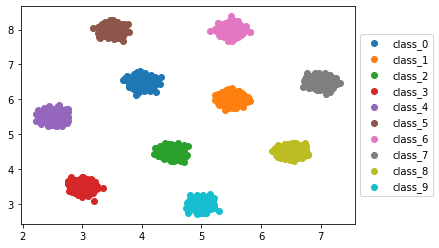

In [4]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

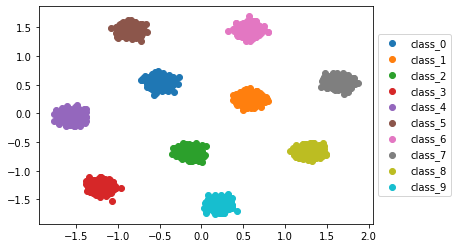

In [6]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [8]:
desired_num = 1100  # 2000 + 1000


m = 100
dims = 2 


mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = 0#np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,dims)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 398.00it/s]


In [9]:
def create_sin_data(mosaic_dataset,labels,fg_n,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches of dimendion 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  """
  n_points = len(mosaic_dataset)
  patches = mosaic_dataset[0].shape[0]
  dims = mosaic_dataset[0].shape[1]
  img = np.zeros((n_points,patches,dims))

  for i in tqdm(range(len(mosaic_dataset))):
    for j in range(m):
      if j < fg_n:
        img[i][j] = mosaic_dataset[i][0]
      else:
        #print(j)
        index = np.random.randint(1,100,1)
        img[i][j]= mosaic_dataset[i][index]
    
    
  return  img,labels

In [10]:
tr = 100
avg_image_dataset_1 , labels_1 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],1,m)
avg_image_dataset_2 , labels_2 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],10,m)
avg_image_dataset_3 , labels_3 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],20,m)
avg_image_dataset_4, labels_4 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],30,m)
avg_image_dataset_5 , labels_5 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],40,m)
avg_image_dataset_6 , labels_6 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],50,m)
avg_image_dataset_7 , labels_7 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],60,m)
avg_image_dataset_8 , labels_8 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],70,m)
avg_image_dataset_9 , labels_9 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],80,m)
avg_image_dataset_10 , labels_10 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],90,m)
avg_image_dataset_11 , labels_11 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],100,m)
avg_image_dataset_12, labels_12 = create_sin_data(mosaic_list_of_images[tr:], mosaic_label[tr:],100,m)


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 14035.47it/s]


In [11]:
avg_image_dataset_1 = np.stack(avg_image_dataset_1)
avg_image_dataset_2 = np.stack(avg_image_dataset_2,axis=0)
avg_image_dataset_3 = np.stack(avg_image_dataset_3,axis=0)
avg_image_dataset_4 = np.stack(avg_image_dataset_4,axis=0)
avg_image_dataset_5 = np.stack(avg_image_dataset_5,axis=0)
avg_image_dataset_6 = np.stack(avg_image_dataset_6,axis=0)
avg_image_dataset_7 = np.stack(avg_image_dataset_7,axis=0)
avg_image_dataset_8 = np.stack(avg_image_dataset_8,axis=0)
avg_image_dataset_9 = np.stack(avg_image_dataset_9,axis=0)
avg_image_dataset_10 = np.stack(avg_image_dataset_10,axis=0)
avg_image_dataset_11 = np.stack(avg_image_dataset_11,axis=0)
avg_image_dataset_12 = np.stack(avg_image_dataset_12,axis=0)

In [12]:
avg_image_dataset_1.shape

(100, 100, 2)

Text(0.5, 1.0, 'Dataset 12')

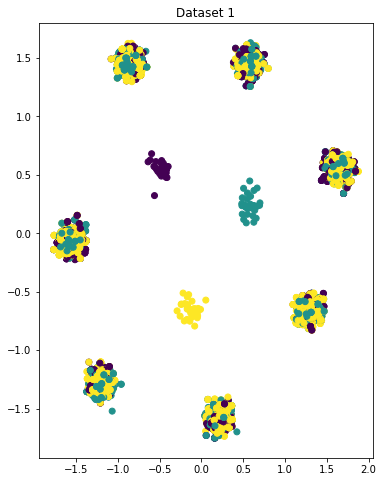

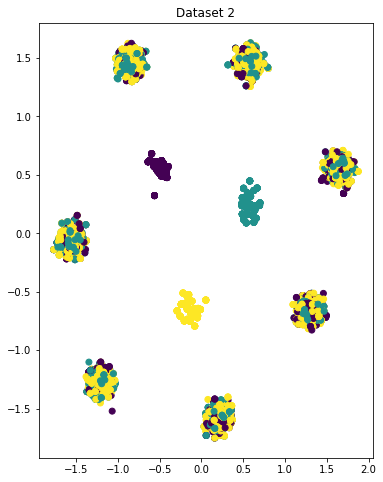

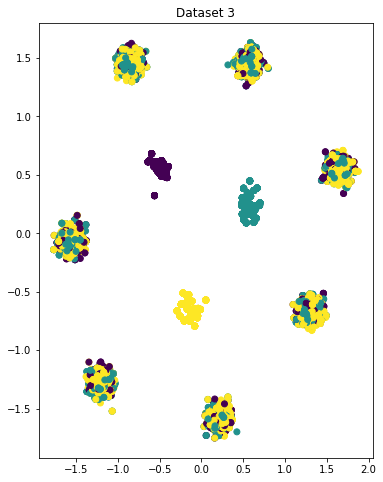

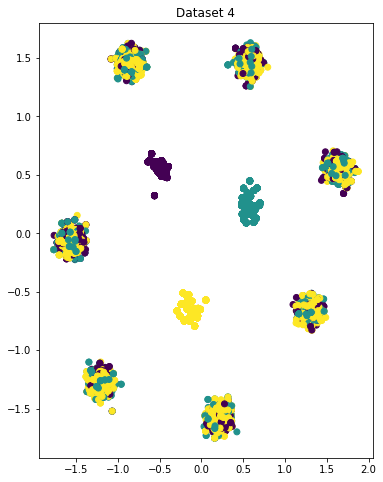

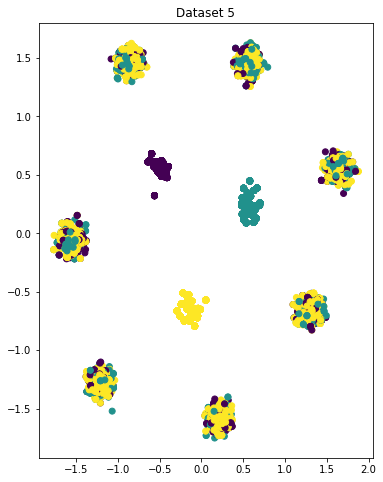

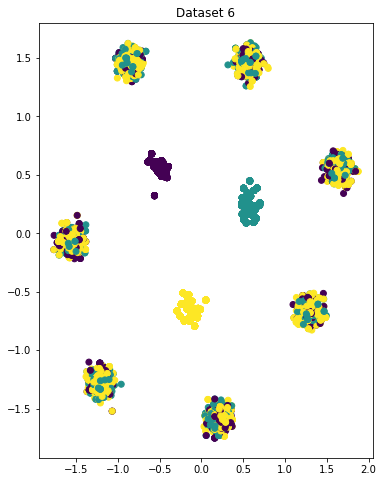

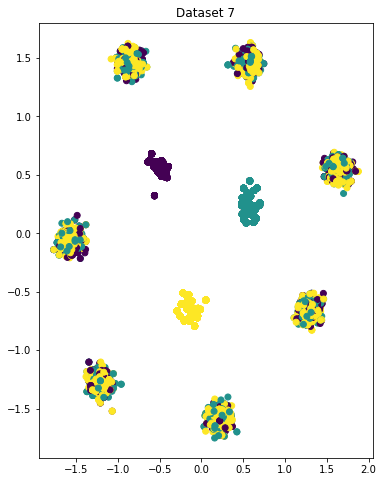

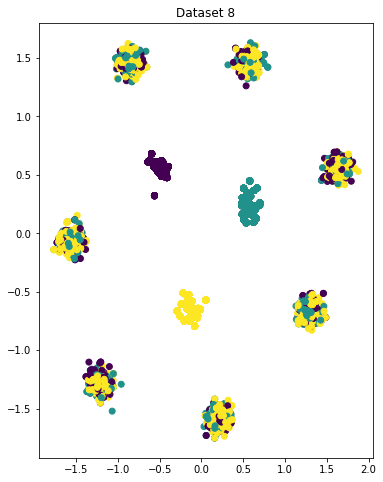

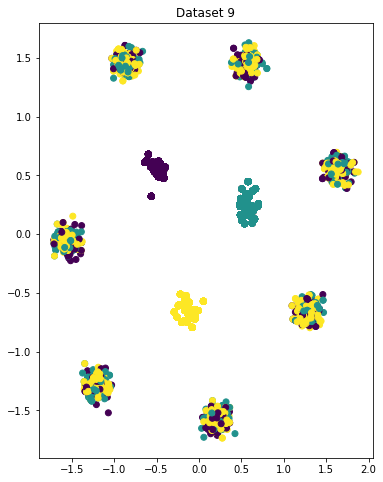

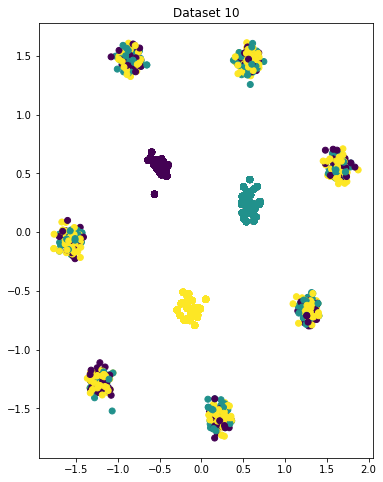

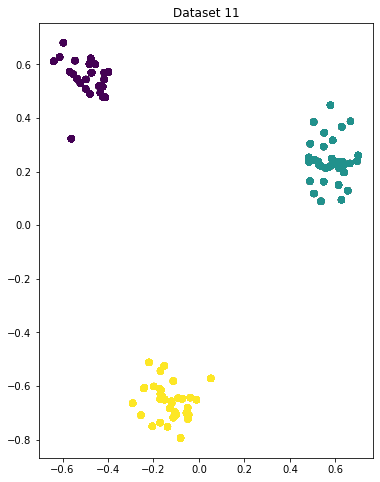

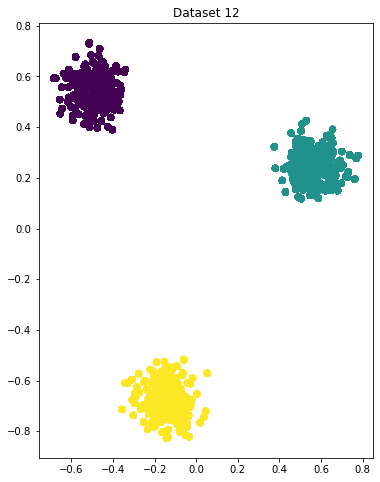

In [13]:
total = 100*m
plt.figure(figsize=(6,8))

temp1 = np.reshape(avg_image_dataset_1,(total,2))
temp_labels = torch.tensor(labels_1).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 1")


plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_2,(total,2))
temp_labels = torch.tensor(labels_2).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 2")



plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_3,(total,2))
temp_labels = torch.tensor(labels_3).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 3")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_4,(total,2))
temp_labels = torch.tensor(labels_4).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 4")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_5,(total,2))
temp_labels = torch.tensor(labels_5).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 5")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_6,(total,2))
temp_labels = torch.tensor(labels_6).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 6")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_7,(total,2))
temp_labels = torch.tensor(labels_7).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 7")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_8,(total,2))
temp_labels = torch.tensor(labels_8).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 8")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_9,(total,2))
temp_labels = torch.tensor(labels_9).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 9")

plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_10,(total,2))
temp_labels = torch.tensor(labels_10).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 10")


plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_11,(total,2))
temp_labels = torch.tensor(labels_11).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 11")


total = 1000*m
plt.figure(figsize=(6,8))
temp1 = np.reshape(avg_image_dataset_12,(total,2))
temp_labels = torch.tensor(labels_12).repeat_interleave(m).numpy()
plt.scatter(temp1[:,0],temp1[:,1],c=temp_labels)
plt.title("Dataset 12")


In [14]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [15]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
trainloader_11 = DataLoader( traindata_11 , batch_size= batch ,shuffle=True)




testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12 )
testloader_12 = DataLoader( testdata_12, batch_size= batch ,shuffle=False)



mosaicdata = MosaicDataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr] )
mosaicloader = DataLoader( mosaicdata , batch_size= batch ,shuffle=True)




In [16]:
data,labels = iter(trainloader_1).next()

In [17]:
data.shape,labels.shape

(torch.Size([100, 100, 2]), torch.Size([100]))

In [18]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.zeros_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [19]:
def calculate_loss_alpha(mosaic_loader,alpha_,net,loss_criterion):
    m = 100
    
    loss_ = []
    with torch.no_grad():
        for i,data in enumerate(mosaic_loader):
            inputs,target =data
            outputs = net(inputs)
            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes))    
            target = target.repeat_interleave(patches)
            #print(outputs.shape,target.shape)
            loss = loss_criterion(outputs,target)
            
            loss = torch.reshape(loss,(batch,patches))
            
            loss_weight = torch.ones((batch,patches))*((1-alpha_)/(m-1))
            
            loss_weight[:,0] = alpha_
            
            loss = torch.mul(loss_weight,loss)
            
            loss = torch.sum(loss,dim=1)
            loss = torch.sum(loss,dim=0)
            
            loss_.append(loss.item()/batch)
    return np.mean(loss_)

In [20]:
def calculate_loss(trainloader,net,criterion):
    running_loss = 0.0
    ep_lossi = []
    with torch.no_grad():
        for k, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            running_loss += loss.item()
            ep_lossi.append(running_loss)
    return np.mean(ep_lossi)

In [21]:
def my_cross_entropy(output,target,loss_criterion):
    
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    output = torch.reshape(output,(batch*patches,classes))    
    target = target.repeat_interleave(patches)
    
    loss = loss_criterion(output,target)
    #print(final_loss)
    return loss

In [22]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    # out = []
    # pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            # out.append(labels.cpu().numpy())
            outputs= net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 

            _, predicted = torch.max(outputs.data, 1)
            # pred.append(predicted.cpu().numpy())
            labels = labels.repeat_interleave(patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [23]:
def train_all(trainloader, ds_number, testloader_list,mosaicloader,alpha):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    
    loss_alpha_h_curi = []
    epochs = 1000
    
    criterion_ = nn.CrossEntropyLoss(reduction='none')
    if alpha ==1.0:
        alpha_ = alpha
    else:
        alpha_ = alpha+0.01
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []
        running_loss = 0.0
        if epoch == 0:    
                loss_curi.append(calculate_loss(trainloader,net,criterion))
        loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 1
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(calculate_loss(trainloader,net,criterion))   #loss per epoch
    print('Finished Training')
    loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
    #torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 
            
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.repeat_interleave(patches)
            #print(predicted.shape,labels.shape,patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    

    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi,loss_alpha_h_curi


In [24]:
train_loss_all=[]
train_loss_alpha_h_all = []

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12]


temp1,temp2 = train_all(trainloader_1, 1, testloader_list,mosaicloader,1/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_2, 2, testloader_list,mosaicloader,10/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_3, 3, testloader_list,mosaicloader,20/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_4, 4, testloader_list,mosaicloader,30/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_5, 5, testloader_list,mosaicloader,40/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_6, 6, testloader_list,mosaicloader,50/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_7, 7, testloader_list,mosaicloader,60/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_8, 8, testloader_list,mosaicloader,70/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_9, 9, testloader_list,mosaicloader,80/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_10, 10, testloader_list,mosaicloader,90/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_11, 11, testloader_list,mosaicloader,100/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

--------------------------------------------------------------------------------
training on data set   1
[1,     1] loss: 1.099
[2,     1] loss: 1.097
[3,     1] loss: 1.096
[4,     1] loss: 1.094
[5,     1] loss: 1.093
[6,     1] loss: 1.092
[7,     1] loss: 1.091
[8,     1] loss: 1.090
[9,     1] loss: 1.090
[10,     1] loss: 1.089
[11,     1] loss: 1.088
[12,     1] loss: 1.088
[13,     1] loss: 1.087
[14,     1] loss: 1.087
[15,     1] loss: 1.086
[16,     1] loss: 1.086
[17,     1] loss: 1.086
[18,     1] loss: 1.085
[19,     1] loss: 1.085
[20,     1] loss: 1.085
[21,     1] loss: 1.085
[22,     1] loss: 1.085
[23,     1] loss: 1.085
[24,     1] loss: 1.085
[25,     1] loss: 1.085
[26,     1] loss: 1.085
[27,     1] loss: 1.085
[28,     1] loss: 1.085
[29,     1] loss: 1.085
[30,     1] loss: 1.085
[31,     1] loss: 1.085
[32,     1] loss: 1.085
[33,     1] loss: 1.085
[34,     1] loss: 1.085
[35,     1] loss: 1.085
[36,     1] loss: 1.085
[37,     1] loss: 1.085
[38,     1] los

[333,     1] loss: 1.085
[334,     1] loss: 1.085
[335,     1] loss: 1.085
[336,     1] loss: 1.085
[337,     1] loss: 1.085
[338,     1] loss: 1.085
[339,     1] loss: 1.085
[340,     1] loss: 1.085
[341,     1] loss: 1.085
[342,     1] loss: 1.085
[343,     1] loss: 1.085
[344,     1] loss: 1.085
[345,     1] loss: 1.085
[346,     1] loss: 1.085
[347,     1] loss: 1.085
[348,     1] loss: 1.085
[349,     1] loss: 1.085
[350,     1] loss: 1.085
[351,     1] loss: 1.085
[352,     1] loss: 1.085
[353,     1] loss: 1.085
[354,     1] loss: 1.085
[355,     1] loss: 1.085
[356,     1] loss: 1.085
[357,     1] loss: 1.085
[358,     1] loss: 1.085
[359,     1] loss: 1.085
[360,     1] loss: 1.085
[361,     1] loss: 1.085
[362,     1] loss: 1.085
[363,     1] loss: 1.085
[364,     1] loss: 1.085
[365,     1] loss: 1.085
[366,     1] loss: 1.085
[367,     1] loss: 1.085
[368,     1] loss: 1.085
[369,     1] loss: 1.085
[370,     1] loss: 1.085
[371,     1] loss: 1.085
[372,     1] loss: 1.085


[672,     1] loss: 1.085
[673,     1] loss: 1.085
[674,     1] loss: 1.085
[675,     1] loss: 1.085
[676,     1] loss: 1.085
[677,     1] loss: 1.085
[678,     1] loss: 1.085
[679,     1] loss: 1.085
[680,     1] loss: 1.085
[681,     1] loss: 1.085
[682,     1] loss: 1.085
[683,     1] loss: 1.085
[684,     1] loss: 1.085
[685,     1] loss: 1.085
[686,     1] loss: 1.085
[687,     1] loss: 1.085
[688,     1] loss: 1.085
[689,     1] loss: 1.085
[690,     1] loss: 1.085
[691,     1] loss: 1.085
[692,     1] loss: 1.085
[693,     1] loss: 1.085
[694,     1] loss: 1.085
[695,     1] loss: 1.085
[696,     1] loss: 1.085
[697,     1] loss: 1.085
[698,     1] loss: 1.085
[699,     1] loss: 1.085
[700,     1] loss: 1.085
[701,     1] loss: 1.085
[702,     1] loss: 1.085
[703,     1] loss: 1.085
[704,     1] loss: 1.085
[705,     1] loss: 1.085
[706,     1] loss: 1.085
[707,     1] loss: 1.085
[708,     1] loss: 1.085
[709,     1] loss: 1.085
[710,     1] loss: 1.085
[711,     1] loss: 1.085


[9,     1] loss: 1.087
[10,     1] loss: 1.087
[11,     1] loss: 1.086
[12,     1] loss: 1.085
[13,     1] loss: 1.085
[14,     1] loss: 1.084
[15,     1] loss: 1.084
[16,     1] loss: 1.084
[17,     1] loss: 1.083
[18,     1] loss: 1.083
[19,     1] loss: 1.083
[20,     1] loss: 1.083
[21,     1] loss: 1.083
[22,     1] loss: 1.082
[23,     1] loss: 1.082
[24,     1] loss: 1.082
[25,     1] loss: 1.082
[26,     1] loss: 1.082
[27,     1] loss: 1.082
[28,     1] loss: 1.082
[29,     1] loss: 1.082
[30,     1] loss: 1.082
[31,     1] loss: 1.082
[32,     1] loss: 1.082
[33,     1] loss: 1.082
[34,     1] loss: 1.082
[35,     1] loss: 1.082
[36,     1] loss: 1.082
[37,     1] loss: 1.082
[38,     1] loss: 1.082
[39,     1] loss: 1.082
[40,     1] loss: 1.082
[41,     1] loss: 1.082
[42,     1] loss: 1.082
[43,     1] loss: 1.082
[44,     1] loss: 1.082
[45,     1] loss: 1.082
[46,     1] loss: 1.082
[47,     1] loss: 1.082
[48,     1] loss: 1.082
[49,     1] loss: 1.082
[50,     1] loss:

[349,     1] loss: 1.082
[350,     1] loss: 1.082
[351,     1] loss: 1.082
[352,     1] loss: 1.082
[353,     1] loss: 1.082
[354,     1] loss: 1.082
[355,     1] loss: 1.082
[356,     1] loss: 1.082
[357,     1] loss: 1.082
[358,     1] loss: 1.082
[359,     1] loss: 1.082
[360,     1] loss: 1.082
[361,     1] loss: 1.082
[362,     1] loss: 1.082
[363,     1] loss: 1.082
[364,     1] loss: 1.082
[365,     1] loss: 1.082
[366,     1] loss: 1.082
[367,     1] loss: 1.082
[368,     1] loss: 1.082
[369,     1] loss: 1.082
[370,     1] loss: 1.082
[371,     1] loss: 1.082
[372,     1] loss: 1.082
[373,     1] loss: 1.082
[374,     1] loss: 1.082
[375,     1] loss: 1.082
[376,     1] loss: 1.082
[377,     1] loss: 1.082
[378,     1] loss: 1.082
[379,     1] loss: 1.082
[380,     1] loss: 1.082
[381,     1] loss: 1.082
[382,     1] loss: 1.082
[383,     1] loss: 1.082
[384,     1] loss: 1.082
[385,     1] loss: 1.082
[386,     1] loss: 1.082
[387,     1] loss: 1.082
[388,     1] loss: 1.082


[685,     1] loss: 1.082
[686,     1] loss: 1.082
[687,     1] loss: 1.082
[688,     1] loss: 1.082
[689,     1] loss: 1.082
[690,     1] loss: 1.082
[691,     1] loss: 1.082
[692,     1] loss: 1.082
[693,     1] loss: 1.082
[694,     1] loss: 1.082
[695,     1] loss: 1.082
[696,     1] loss: 1.082
[697,     1] loss: 1.082
[698,     1] loss: 1.082
[699,     1] loss: 1.082
[700,     1] loss: 1.082
[701,     1] loss: 1.082
[702,     1] loss: 1.082
[703,     1] loss: 1.082
[704,     1] loss: 1.082
[705,     1] loss: 1.082
[706,     1] loss: 1.082
[707,     1] loss: 1.082
[708,     1] loss: 1.082
[709,     1] loss: 1.082
[710,     1] loss: 1.082
[711,     1] loss: 1.082
[712,     1] loss: 1.082
[713,     1] loss: 1.082
[714,     1] loss: 1.082
[715,     1] loss: 1.082
[716,     1] loss: 1.082
[717,     1] loss: 1.082
[718,     1] loss: 1.082
[719,     1] loss: 1.082
[720,     1] loss: 1.082
[721,     1] loss: 1.082
[722,     1] loss: 1.082
[723,     1] loss: 1.082
[724,     1] loss: 1.082


[5,     1] loss: 1.089
[6,     1] loss: 1.087
[7,     1] loss: 1.086
[8,     1] loss: 1.085
[9,     1] loss: 1.084
[10,     1] loss: 1.083
[11,     1] loss: 1.082
[12,     1] loss: 1.081
[13,     1] loss: 1.081
[14,     1] loss: 1.080
[15,     1] loss: 1.080
[16,     1] loss: 1.079
[17,     1] loss: 1.079
[18,     1] loss: 1.079
[19,     1] loss: 1.079
[20,     1] loss: 1.078
[21,     1] loss: 1.078
[22,     1] loss: 1.078
[23,     1] loss: 1.078
[24,     1] loss: 1.078
[25,     1] loss: 1.078
[26,     1] loss: 1.078
[27,     1] loss: 1.078
[28,     1] loss: 1.078
[29,     1] loss: 1.078
[30,     1] loss: 1.078
[31,     1] loss: 1.078
[32,     1] loss: 1.078
[33,     1] loss: 1.078
[34,     1] loss: 1.078
[35,     1] loss: 1.078
[36,     1] loss: 1.078
[37,     1] loss: 1.078
[38,     1] loss: 1.078
[39,     1] loss: 1.078
[40,     1] loss: 1.078
[41,     1] loss: 1.078
[42,     1] loss: 1.078
[43,     1] loss: 1.078
[44,     1] loss: 1.078
[45,     1] loss: 1.078
[46,     1] loss: 1.0

[344,     1] loss: 1.078
[345,     1] loss: 1.078
[346,     1] loss: 1.078
[347,     1] loss: 1.078
[348,     1] loss: 1.078
[349,     1] loss: 1.078
[350,     1] loss: 1.078
[351,     1] loss: 1.078
[352,     1] loss: 1.078
[353,     1] loss: 1.078
[354,     1] loss: 1.078
[355,     1] loss: 1.078
[356,     1] loss: 1.078
[357,     1] loss: 1.078
[358,     1] loss: 1.078
[359,     1] loss: 1.078
[360,     1] loss: 1.078
[361,     1] loss: 1.078
[362,     1] loss: 1.078
[363,     1] loss: 1.078
[364,     1] loss: 1.078
[365,     1] loss: 1.078
[366,     1] loss: 1.078
[367,     1] loss: 1.078
[368,     1] loss: 1.078
[369,     1] loss: 1.078
[370,     1] loss: 1.078
[371,     1] loss: 1.078
[372,     1] loss: 1.078
[373,     1] loss: 1.078
[374,     1] loss: 1.078
[375,     1] loss: 1.078
[376,     1] loss: 1.078
[377,     1] loss: 1.078
[378,     1] loss: 1.078
[379,     1] loss: 1.078
[380,     1] loss: 1.078
[381,     1] loss: 1.078
[382,     1] loss: 1.078
[383,     1] loss: 1.078


[683,     1] loss: 1.078
[684,     1] loss: 1.078
[685,     1] loss: 1.078
[686,     1] loss: 1.078
[687,     1] loss: 1.078
[688,     1] loss: 1.078
[689,     1] loss: 1.078
[690,     1] loss: 1.078
[691,     1] loss: 1.078
[692,     1] loss: 1.078
[693,     1] loss: 1.078
[694,     1] loss: 1.078
[695,     1] loss: 1.078
[696,     1] loss: 1.078
[697,     1] loss: 1.078
[698,     1] loss: 1.078
[699,     1] loss: 1.078
[700,     1] loss: 1.078
[701,     1] loss: 1.078
[702,     1] loss: 1.078
[703,     1] loss: 1.078
[704,     1] loss: 1.078
[705,     1] loss: 1.078
[706,     1] loss: 1.078
[707,     1] loss: 1.078
[708,     1] loss: 1.078
[709,     1] loss: 1.078
[710,     1] loss: 1.078
[711,     1] loss: 1.078
[712,     1] loss: 1.078
[713,     1] loss: 1.078
[714,     1] loss: 1.078
[715,     1] loss: 1.078
[716,     1] loss: 1.078
[717,     1] loss: 1.078
[718,     1] loss: 1.078
[719,     1] loss: 1.078
[720,     1] loss: 1.078
[721,     1] loss: 1.078
[722,     1] loss: 1.078


[20,     1] loss: 1.065
[21,     1] loss: 1.065
[22,     1] loss: 1.064
[23,     1] loss: 1.064
[24,     1] loss: 1.064
[25,     1] loss: 1.064
[26,     1] loss: 1.064
[27,     1] loss: 1.064
[28,     1] loss: 1.064
[29,     1] loss: 1.064
[30,     1] loss: 1.064
[31,     1] loss: 1.064
[32,     1] loss: 1.064
[33,     1] loss: 1.064
[34,     1] loss: 1.064
[35,     1] loss: 1.064
[36,     1] loss: 1.064
[37,     1] loss: 1.064
[38,     1] loss: 1.064
[39,     1] loss: 1.064
[40,     1] loss: 1.064
[41,     1] loss: 1.064
[42,     1] loss: 1.064
[43,     1] loss: 1.064
[44,     1] loss: 1.064
[45,     1] loss: 1.064
[46,     1] loss: 1.064
[47,     1] loss: 1.064
[48,     1] loss: 1.064
[49,     1] loss: 1.064
[50,     1] loss: 1.064
[51,     1] loss: 1.064
[52,     1] loss: 1.064
[53,     1] loss: 1.064
[54,     1] loss: 1.064
[55,     1] loss: 1.064
[56,     1] loss: 1.064
[57,     1] loss: 1.064
[58,     1] loss: 1.064
[59,     1] loss: 1.064
[60,     1] loss: 1.064
[61,     1] loss

[362,     1] loss: 1.064
[363,     1] loss: 1.064
[364,     1] loss: 1.064
[365,     1] loss: 1.064
[366,     1] loss: 1.064
[367,     1] loss: 1.064
[368,     1] loss: 1.064
[369,     1] loss: 1.064
[370,     1] loss: 1.064
[371,     1] loss: 1.064
[372,     1] loss: 1.064
[373,     1] loss: 1.064
[374,     1] loss: 1.064
[375,     1] loss: 1.064
[376,     1] loss: 1.064
[377,     1] loss: 1.064
[378,     1] loss: 1.064
[379,     1] loss: 1.064
[380,     1] loss: 1.064
[381,     1] loss: 1.064
[382,     1] loss: 1.064
[383,     1] loss: 1.064
[384,     1] loss: 1.064
[385,     1] loss: 1.064
[386,     1] loss: 1.064
[387,     1] loss: 1.064
[388,     1] loss: 1.064
[389,     1] loss: 1.064
[390,     1] loss: 1.064
[391,     1] loss: 1.064
[392,     1] loss: 1.064
[393,     1] loss: 1.064
[394,     1] loss: 1.064
[395,     1] loss: 1.064
[396,     1] loss: 1.064
[397,     1] loss: 1.064
[398,     1] loss: 1.064
[399,     1] loss: 1.064
[400,     1] loss: 1.064
[401,     1] loss: 1.064


[699,     1] loss: 1.064
[700,     1] loss: 1.064
[701,     1] loss: 1.064
[702,     1] loss: 1.064
[703,     1] loss: 1.064
[704,     1] loss: 1.064
[705,     1] loss: 1.064
[706,     1] loss: 1.064
[707,     1] loss: 1.064
[708,     1] loss: 1.064
[709,     1] loss: 1.064
[710,     1] loss: 1.064
[711,     1] loss: 1.064
[712,     1] loss: 1.064
[713,     1] loss: 1.064
[714,     1] loss: 1.064
[715,     1] loss: 1.064
[716,     1] loss: 1.064
[717,     1] loss: 1.064
[718,     1] loss: 1.064
[719,     1] loss: 1.064
[720,     1] loss: 1.064
[721,     1] loss: 1.064
[722,     1] loss: 1.064
[723,     1] loss: 1.064
[724,     1] loss: 1.064
[725,     1] loss: 1.064
[726,     1] loss: 1.064
[727,     1] loss: 1.064
[728,     1] loss: 1.064
[729,     1] loss: 1.064
[730,     1] loss: 1.064
[731,     1] loss: 1.064
[732,     1] loss: 1.064
[733,     1] loss: 1.064
[734,     1] loss: 1.064
[735,     1] loss: 1.064
[736,     1] loss: 1.064
[737,     1] loss: 1.064
[738,     1] loss: 1.064


[33,     1] loss: 1.047
[34,     1] loss: 1.047
[35,     1] loss: 1.047
[36,     1] loss: 1.047
[37,     1] loss: 1.047
[38,     1] loss: 1.047
[39,     1] loss: 1.047
[40,     1] loss: 1.047
[41,     1] loss: 1.047
[42,     1] loss: 1.047
[43,     1] loss: 1.047
[44,     1] loss: 1.047
[45,     1] loss: 1.047
[46,     1] loss: 1.047
[47,     1] loss: 1.047
[48,     1] loss: 1.047
[49,     1] loss: 1.047
[50,     1] loss: 1.047
[51,     1] loss: 1.047
[52,     1] loss: 1.047
[53,     1] loss: 1.047
[54,     1] loss: 1.047
[55,     1] loss: 1.047
[56,     1] loss: 1.047
[57,     1] loss: 1.047
[58,     1] loss: 1.047
[59,     1] loss: 1.047
[60,     1] loss: 1.047
[61,     1] loss: 1.047
[62,     1] loss: 1.047
[63,     1] loss: 1.047
[64,     1] loss: 1.047
[65,     1] loss: 1.047
[66,     1] loss: 1.047
[67,     1] loss: 1.047
[68,     1] loss: 1.047
[69,     1] loss: 1.047
[70,     1] loss: 1.047
[71,     1] loss: 1.047
[72,     1] loss: 1.047
[73,     1] loss: 1.047
[74,     1] loss

[374,     1] loss: 1.047
[375,     1] loss: 1.047
[376,     1] loss: 1.047
[377,     1] loss: 1.047
[378,     1] loss: 1.047
[379,     1] loss: 1.047
[380,     1] loss: 1.047
[381,     1] loss: 1.047
[382,     1] loss: 1.047
[383,     1] loss: 1.047
[384,     1] loss: 1.047
[385,     1] loss: 1.047
[386,     1] loss: 1.047
[387,     1] loss: 1.047
[388,     1] loss: 1.047
[389,     1] loss: 1.047
[390,     1] loss: 1.047
[391,     1] loss: 1.047
[392,     1] loss: 1.047
[393,     1] loss: 1.047
[394,     1] loss: 1.047
[395,     1] loss: 1.047
[396,     1] loss: 1.047
[397,     1] loss: 1.047
[398,     1] loss: 1.047
[399,     1] loss: 1.047
[400,     1] loss: 1.047
[401,     1] loss: 1.047
[402,     1] loss: 1.047
[403,     1] loss: 1.047
[404,     1] loss: 1.047
[405,     1] loss: 1.047
[406,     1] loss: 1.047
[407,     1] loss: 1.047
[408,     1] loss: 1.047
[409,     1] loss: 1.047
[410,     1] loss: 1.047
[411,     1] loss: 1.047
[412,     1] loss: 1.047
[413,     1] loss: 1.047


[718,     1] loss: 1.047
[719,     1] loss: 1.047
[720,     1] loss: 1.047
[721,     1] loss: 1.047
[722,     1] loss: 1.047
[723,     1] loss: 1.047
[724,     1] loss: 1.047
[725,     1] loss: 1.047
[726,     1] loss: 1.047
[727,     1] loss: 1.047
[728,     1] loss: 1.047
[729,     1] loss: 1.047
[730,     1] loss: 1.047
[731,     1] loss: 1.047
[732,     1] loss: 1.047
[733,     1] loss: 1.047
[734,     1] loss: 1.047
[735,     1] loss: 1.047
[736,     1] loss: 1.047
[737,     1] loss: 1.047
[738,     1] loss: 1.047
[739,     1] loss: 1.047
[740,     1] loss: 1.047
[741,     1] loss: 1.047
[742,     1] loss: 1.047
[743,     1] loss: 1.047
[744,     1] loss: 1.047
[745,     1] loss: 1.047
[746,     1] loss: 1.047
[747,     1] loss: 1.047
[748,     1] loss: 1.047
[749,     1] loss: 1.047
[750,     1] loss: 1.047
[751,     1] loss: 1.047
[752,     1] loss: 1.047
[753,     1] loss: 1.047
[754,     1] loss: 1.047
[755,     1] loss: 1.047
[756,     1] loss: 1.047
[757,     1] loss: 1.047


[54,     1] loss: 1.011
[55,     1] loss: 1.011
[56,     1] loss: 1.011
[57,     1] loss: 1.011
[58,     1] loss: 1.011
[59,     1] loss: 1.011
[60,     1] loss: 1.011
[61,     1] loss: 1.011
[62,     1] loss: 1.011
[63,     1] loss: 1.011
[64,     1] loss: 1.011
[65,     1] loss: 1.011
[66,     1] loss: 1.011
[67,     1] loss: 1.011
[68,     1] loss: 1.011
[69,     1] loss: 1.011
[70,     1] loss: 1.011
[71,     1] loss: 1.011
[72,     1] loss: 1.011
[73,     1] loss: 1.011
[74,     1] loss: 1.011
[75,     1] loss: 1.011
[76,     1] loss: 1.011
[77,     1] loss: 1.011
[78,     1] loss: 1.011
[79,     1] loss: 1.011
[80,     1] loss: 1.011
[81,     1] loss: 1.011
[82,     1] loss: 1.011
[83,     1] loss: 1.011
[84,     1] loss: 1.011
[85,     1] loss: 1.011
[86,     1] loss: 1.011
[87,     1] loss: 1.011
[88,     1] loss: 1.011
[89,     1] loss: 1.011
[90,     1] loss: 1.011
[91,     1] loss: 1.011
[92,     1] loss: 1.011
[93,     1] loss: 1.011
[94,     1] loss: 1.011
[95,     1] loss

[425,     1] loss: 1.011
[426,     1] loss: 1.011
[427,     1] loss: 1.011
[428,     1] loss: 1.011
[429,     1] loss: 1.011
[430,     1] loss: 1.011
[431,     1] loss: 1.011
[432,     1] loss: 1.011
[433,     1] loss: 1.011
[434,     1] loss: 1.011
[435,     1] loss: 1.011
[436,     1] loss: 1.011
[437,     1] loss: 1.011
[438,     1] loss: 1.011
[439,     1] loss: 1.011
[440,     1] loss: 1.011
[441,     1] loss: 1.011
[442,     1] loss: 1.011
[443,     1] loss: 1.011
[444,     1] loss: 1.011
[445,     1] loss: 1.011
[446,     1] loss: 1.011
[447,     1] loss: 1.011
[448,     1] loss: 1.011
[449,     1] loss: 1.011
[450,     1] loss: 1.011
[451,     1] loss: 1.011
[452,     1] loss: 1.011
[453,     1] loss: 1.011
[454,     1] loss: 1.011
[455,     1] loss: 1.011
[456,     1] loss: 1.011
[457,     1] loss: 1.011
[458,     1] loss: 1.011
[459,     1] loss: 1.011
[460,     1] loss: 1.011
[461,     1] loss: 1.011
[462,     1] loss: 1.011
[463,     1] loss: 1.011
[464,     1] loss: 1.011


[764,     1] loss: 1.011
[765,     1] loss: 1.011
[766,     1] loss: 1.011
[767,     1] loss: 1.011
[768,     1] loss: 1.011
[769,     1] loss: 1.011
[770,     1] loss: 1.011
[771,     1] loss: 1.011
[772,     1] loss: 1.011
[773,     1] loss: 1.011
[774,     1] loss: 1.011
[775,     1] loss: 1.011
[776,     1] loss: 1.011
[777,     1] loss: 1.011
[778,     1] loss: 1.011
[779,     1] loss: 1.011
[780,     1] loss: 1.011
[781,     1] loss: 1.011
[782,     1] loss: 1.011
[783,     1] loss: 1.011
[784,     1] loss: 1.011
[785,     1] loss: 1.011
[786,     1] loss: 1.011
[787,     1] loss: 1.011
[788,     1] loss: 1.011
[789,     1] loss: 1.011
[790,     1] loss: 1.011
[791,     1] loss: 1.011
[792,     1] loss: 1.011
[793,     1] loss: 1.011
[794,     1] loss: 1.011
[795,     1] loss: 1.011
[796,     1] loss: 1.011
[797,     1] loss: 1.011
[798,     1] loss: 1.011
[799,     1] loss: 1.011
[800,     1] loss: 1.011
[801,     1] loss: 1.011
[802,     1] loss: 1.011
[803,     1] loss: 1.011


[100,     1] loss: 0.959
[101,     1] loss: 0.959
[102,     1] loss: 0.959
[103,     1] loss: 0.959
[104,     1] loss: 0.959
[105,     1] loss: 0.959
[106,     1] loss: 0.959
[107,     1] loss: 0.959
[108,     1] loss: 0.959
[109,     1] loss: 0.959
[110,     1] loss: 0.959
[111,     1] loss: 0.959
[112,     1] loss: 0.959
[113,     1] loss: 0.959
[114,     1] loss: 0.959
[115,     1] loss: 0.959
[116,     1] loss: 0.959
[117,     1] loss: 0.959
[118,     1] loss: 0.959
[119,     1] loss: 0.959
[120,     1] loss: 0.959
[121,     1] loss: 0.959
[122,     1] loss: 0.959
[123,     1] loss: 0.959
[124,     1] loss: 0.959
[125,     1] loss: 0.959
[126,     1] loss: 0.959
[127,     1] loss: 0.959
[128,     1] loss: 0.959
[129,     1] loss: 0.959
[130,     1] loss: 0.959
[131,     1] loss: 0.959
[132,     1] loss: 0.959
[133,     1] loss: 0.959
[134,     1] loss: 0.959
[135,     1] loss: 0.959
[136,     1] loss: 0.959
[137,     1] loss: 0.959
[138,     1] loss: 0.959
[139,     1] loss: 0.959


[436,     1] loss: 0.959
[437,     1] loss: 0.959
[438,     1] loss: 0.959
[439,     1] loss: 0.959
[440,     1] loss: 0.959
[441,     1] loss: 0.959
[442,     1] loss: 0.959
[443,     1] loss: 0.959
[444,     1] loss: 0.959
[445,     1] loss: 0.959
[446,     1] loss: 0.959
[447,     1] loss: 0.959
[448,     1] loss: 0.959
[449,     1] loss: 0.959
[450,     1] loss: 0.959
[451,     1] loss: 0.959
[452,     1] loss: 0.959
[453,     1] loss: 0.959
[454,     1] loss: 0.959
[455,     1] loss: 0.959
[456,     1] loss: 0.959
[457,     1] loss: 0.959
[458,     1] loss: 0.959
[459,     1] loss: 0.959
[460,     1] loss: 0.959
[461,     1] loss: 0.959
[462,     1] loss: 0.959
[463,     1] loss: 0.959
[464,     1] loss: 0.959
[465,     1] loss: 0.959
[466,     1] loss: 0.959
[467,     1] loss: 0.959
[468,     1] loss: 0.959
[469,     1] loss: 0.959
[470,     1] loss: 0.959
[471,     1] loss: 0.959
[472,     1] loss: 0.959
[473,     1] loss: 0.959
[474,     1] loss: 0.959
[475,     1] loss: 0.959


[773,     1] loss: 0.959
[774,     1] loss: 0.959
[775,     1] loss: 0.959
[776,     1] loss: 0.959
[777,     1] loss: 0.959
[778,     1] loss: 0.959
[779,     1] loss: 0.959
[780,     1] loss: 0.959
[781,     1] loss: 0.959
[782,     1] loss: 0.959
[783,     1] loss: 0.959
[784,     1] loss: 0.959
[785,     1] loss: 0.959
[786,     1] loss: 0.959
[787,     1] loss: 0.959
[788,     1] loss: 0.959
[789,     1] loss: 0.959
[790,     1] loss: 0.959
[791,     1] loss: 0.959
[792,     1] loss: 0.959
[793,     1] loss: 0.959
[794,     1] loss: 0.959
[795,     1] loss: 0.959
[796,     1] loss: 0.959
[797,     1] loss: 0.959
[798,     1] loss: 0.959
[799,     1] loss: 0.959
[800,     1] loss: 0.959
[801,     1] loss: 0.959
[802,     1] loss: 0.959
[803,     1] loss: 0.959
[804,     1] loss: 0.959
[805,     1] loss: 0.959
[806,     1] loss: 0.959
[807,     1] loss: 0.959
[808,     1] loss: 0.959
[809,     1] loss: 0.959
[810,     1] loss: 0.959
[811,     1] loss: 0.959
[812,     1] loss: 0.959


[103,     1] loss: 0.877
[104,     1] loss: 0.877
[105,     1] loss: 0.877
[106,     1] loss: 0.876
[107,     1] loss: 0.876
[108,     1] loss: 0.876
[109,     1] loss: 0.876
[110,     1] loss: 0.876
[111,     1] loss: 0.876
[112,     1] loss: 0.875
[113,     1] loss: 0.875
[114,     1] loss: 0.875
[115,     1] loss: 0.875
[116,     1] loss: 0.875
[117,     1] loss: 0.875
[118,     1] loss: 0.875
[119,     1] loss: 0.875
[120,     1] loss: 0.874
[121,     1] loss: 0.874
[122,     1] loss: 0.874
[123,     1] loss: 0.874
[124,     1] loss: 0.874
[125,     1] loss: 0.874
[126,     1] loss: 0.874
[127,     1] loss: 0.874
[128,     1] loss: 0.874
[129,     1] loss: 0.874
[130,     1] loss: 0.873
[131,     1] loss: 0.873
[132,     1] loss: 0.873
[133,     1] loss: 0.873
[134,     1] loss: 0.873
[135,     1] loss: 0.873
[136,     1] loss: 0.873
[137,     1] loss: 0.873
[138,     1] loss: 0.873
[139,     1] loss: 0.873
[140,     1] loss: 0.873
[141,     1] loss: 0.873
[142,     1] loss: 0.873


[440,     1] loss: 0.872
[441,     1] loss: 0.872
[442,     1] loss: 0.872
[443,     1] loss: 0.872
[444,     1] loss: 0.872
[445,     1] loss: 0.872
[446,     1] loss: 0.872
[447,     1] loss: 0.872
[448,     1] loss: 0.872
[449,     1] loss: 0.872
[450,     1] loss: 0.872
[451,     1] loss: 0.872
[452,     1] loss: 0.872
[453,     1] loss: 0.872
[454,     1] loss: 0.872
[455,     1] loss: 0.872
[456,     1] loss: 0.872
[457,     1] loss: 0.872
[458,     1] loss: 0.872
[459,     1] loss: 0.872
[460,     1] loss: 0.872
[461,     1] loss: 0.872
[462,     1] loss: 0.872
[463,     1] loss: 0.872
[464,     1] loss: 0.872
[465,     1] loss: 0.872
[466,     1] loss: 0.872
[467,     1] loss: 0.872
[468,     1] loss: 0.872
[469,     1] loss: 0.872
[470,     1] loss: 0.872
[471,     1] loss: 0.872
[472,     1] loss: 0.872
[473,     1] loss: 0.872
[474,     1] loss: 0.872
[475,     1] loss: 0.872
[476,     1] loss: 0.872
[477,     1] loss: 0.872
[478,     1] loss: 0.872
[479,     1] loss: 0.872


[780,     1] loss: 0.872
[781,     1] loss: 0.872
[782,     1] loss: 0.872
[783,     1] loss: 0.872
[784,     1] loss: 0.872
[785,     1] loss: 0.872
[786,     1] loss: 0.872
[787,     1] loss: 0.872
[788,     1] loss: 0.872
[789,     1] loss: 0.872
[790,     1] loss: 0.872
[791,     1] loss: 0.872
[792,     1] loss: 0.872
[793,     1] loss: 0.872
[794,     1] loss: 0.872
[795,     1] loss: 0.872
[796,     1] loss: 0.872
[797,     1] loss: 0.872
[798,     1] loss: 0.872
[799,     1] loss: 0.872
[800,     1] loss: 0.872
[801,     1] loss: 0.872
[802,     1] loss: 0.872
[803,     1] loss: 0.872
[804,     1] loss: 0.872
[805,     1] loss: 0.872
[806,     1] loss: 0.872
[807,     1] loss: 0.872
[808,     1] loss: 0.872
[809,     1] loss: 0.872
[810,     1] loss: 0.872
[811,     1] loss: 0.872
[812,     1] loss: 0.872
[813,     1] loss: 0.872
[814,     1] loss: 0.872
[815,     1] loss: 0.872
[816,     1] loss: 0.872
[817,     1] loss: 0.872
[818,     1] loss: 0.872
[819,     1] loss: 0.872


[109,     1] loss: 0.766
[110,     1] loss: 0.765
[111,     1] loss: 0.764
[112,     1] loss: 0.763
[113,     1] loss: 0.763
[114,     1] loss: 0.762
[115,     1] loss: 0.761
[116,     1] loss: 0.761
[117,     1] loss: 0.760
[118,     1] loss: 0.760
[119,     1] loss: 0.759
[120,     1] loss: 0.758
[121,     1] loss: 0.758
[122,     1] loss: 0.757
[123,     1] loss: 0.757
[124,     1] loss: 0.756
[125,     1] loss: 0.756
[126,     1] loss: 0.755
[127,     1] loss: 0.755
[128,     1] loss: 0.754
[129,     1] loss: 0.754
[130,     1] loss: 0.753
[131,     1] loss: 0.753
[132,     1] loss: 0.752
[133,     1] loss: 0.752
[134,     1] loss: 0.751
[135,     1] loss: 0.751
[136,     1] loss: 0.751
[137,     1] loss: 0.750
[138,     1] loss: 0.750
[139,     1] loss: 0.749
[140,     1] loss: 0.749
[141,     1] loss: 0.749
[142,     1] loss: 0.748
[143,     1] loss: 0.748
[144,     1] loss: 0.748
[145,     1] loss: 0.747
[146,     1] loss: 0.747
[147,     1] loss: 0.747
[148,     1] loss: 0.746


[444,     1] loss: 0.733
[445,     1] loss: 0.733
[446,     1] loss: 0.733
[447,     1] loss: 0.733
[448,     1] loss: 0.733
[449,     1] loss: 0.733
[450,     1] loss: 0.733
[451,     1] loss: 0.733
[452,     1] loss: 0.733
[453,     1] loss: 0.733
[454,     1] loss: 0.733
[455,     1] loss: 0.733
[456,     1] loss: 0.733
[457,     1] loss: 0.733
[458,     1] loss: 0.733
[459,     1] loss: 0.733
[460,     1] loss: 0.733
[461,     1] loss: 0.733
[462,     1] loss: 0.733
[463,     1] loss: 0.733
[464,     1] loss: 0.733
[465,     1] loss: 0.733
[466,     1] loss: 0.733
[467,     1] loss: 0.733
[468,     1] loss: 0.733
[469,     1] loss: 0.733
[470,     1] loss: 0.733
[471,     1] loss: 0.733
[472,     1] loss: 0.733
[473,     1] loss: 0.733
[474,     1] loss: 0.733
[475,     1] loss: 0.733
[476,     1] loss: 0.733
[477,     1] loss: 0.733
[478,     1] loss: 0.733
[479,     1] loss: 0.733
[480,     1] loss: 0.733
[481,     1] loss: 0.733
[482,     1] loss: 0.733
[483,     1] loss: 0.733


[808,     1] loss: 0.733
[809,     1] loss: 0.733
[810,     1] loss: 0.733
[811,     1] loss: 0.733
[812,     1] loss: 0.733
[813,     1] loss: 0.733
[814,     1] loss: 0.733
[815,     1] loss: 0.733
[816,     1] loss: 0.733
[817,     1] loss: 0.733
[818,     1] loss: 0.733
[819,     1] loss: 0.733
[820,     1] loss: 0.733
[821,     1] loss: 0.733
[822,     1] loss: 0.733
[823,     1] loss: 0.733
[824,     1] loss: 0.733
[825,     1] loss: 0.733
[826,     1] loss: 0.733
[827,     1] loss: 0.733
[828,     1] loss: 0.733
[829,     1] loss: 0.733
[830,     1] loss: 0.733
[831,     1] loss: 0.733
[832,     1] loss: 0.733
[833,     1] loss: 0.733
[834,     1] loss: 0.733
[835,     1] loss: 0.733
[836,     1] loss: 0.733
[837,     1] loss: 0.733
[838,     1] loss: 0.733
[839,     1] loss: 0.733
[840,     1] loss: 0.733
[841,     1] loss: 0.733
[842,     1] loss: 0.733
[843,     1] loss: 0.733
[844,     1] loss: 0.733
[845,     1] loss: 0.733
[846,     1] loss: 0.733
[847,     1] loss: 0.733


[130,     1] loss: 0.581
[131,     1] loss: 0.580
[132,     1] loss: 0.579
[133,     1] loss: 0.577
[134,     1] loss: 0.576
[135,     1] loss: 0.575
[136,     1] loss: 0.573
[137,     1] loss: 0.572
[138,     1] loss: 0.571
[139,     1] loss: 0.569
[140,     1] loss: 0.568
[141,     1] loss: 0.567
[142,     1] loss: 0.566
[143,     1] loss: 0.565
[144,     1] loss: 0.563
[145,     1] loss: 0.562
[146,     1] loss: 0.561
[147,     1] loss: 0.560
[148,     1] loss: 0.559
[149,     1] loss: 0.558
[150,     1] loss: 0.557
[151,     1] loss: 0.556
[152,     1] loss: 0.555
[153,     1] loss: 0.554
[154,     1] loss: 0.553
[155,     1] loss: 0.552
[156,     1] loss: 0.551
[157,     1] loss: 0.550
[158,     1] loss: 0.549
[159,     1] loss: 0.548
[160,     1] loss: 0.547
[161,     1] loss: 0.546
[162,     1] loss: 0.545
[163,     1] loss: 0.544
[164,     1] loss: 0.543
[165,     1] loss: 0.542
[166,     1] loss: 0.541
[167,     1] loss: 0.540
[168,     1] loss: 0.540
[169,     1] loss: 0.539


[502,     1] loss: 0.477
[503,     1] loss: 0.477
[504,     1] loss: 0.477
[505,     1] loss: 0.477
[506,     1] loss: 0.477
[507,     1] loss: 0.477
[508,     1] loss: 0.477
[509,     1] loss: 0.477
[510,     1] loss: 0.477
[511,     1] loss: 0.477
[512,     1] loss: 0.477
[513,     1] loss: 0.477
[514,     1] loss: 0.477
[515,     1] loss: 0.476
[516,     1] loss: 0.476
[517,     1] loss: 0.476
[518,     1] loss: 0.476
[519,     1] loss: 0.476
[520,     1] loss: 0.476
[521,     1] loss: 0.476
[522,     1] loss: 0.476
[523,     1] loss: 0.476
[524,     1] loss: 0.476
[525,     1] loss: 0.476
[526,     1] loss: 0.476
[527,     1] loss: 0.476
[528,     1] loss: 0.476
[529,     1] loss: 0.476
[530,     1] loss: 0.476
[531,     1] loss: 0.476
[532,     1] loss: 0.476
[533,     1] loss: 0.476
[534,     1] loss: 0.476
[535,     1] loss: 0.476
[536,     1] loss: 0.476
[537,     1] loss: 0.476
[538,     1] loss: 0.476
[539,     1] loss: 0.476
[540,     1] loss: 0.476
[541,     1] loss: 0.476


[871,     1] loss: 0.476
[872,     1] loss: 0.476
[873,     1] loss: 0.476
[874,     1] loss: 0.476
[875,     1] loss: 0.476
[876,     1] loss: 0.476
[877,     1] loss: 0.476
[878,     1] loss: 0.476
[879,     1] loss: 0.476
[880,     1] loss: 0.476
[881,     1] loss: 0.476
[882,     1] loss: 0.476
[883,     1] loss: 0.476
[884,     1] loss: 0.476
[885,     1] loss: 0.476
[886,     1] loss: 0.476
[887,     1] loss: 0.476
[888,     1] loss: 0.476
[889,     1] loss: 0.476
[890,     1] loss: 0.476
[891,     1] loss: 0.476
[892,     1] loss: 0.476
[893,     1] loss: 0.476
[894,     1] loss: 0.476
[895,     1] loss: 0.476
[896,     1] loss: 0.476
[897,     1] loss: 0.476
[898,     1] loss: 0.476
[899,     1] loss: 0.476
[900,     1] loss: 0.476
[901,     1] loss: 0.476
[902,     1] loss: 0.476
[903,     1] loss: 0.476
[904,     1] loss: 0.476
[905,     1] loss: 0.476
[906,     1] loss: 0.476
[907,     1] loss: 0.476
[908,     1] loss: 0.476
[909,     1] loss: 0.476
[910,     1] loss: 0.476


[193,     1] loss: 0.256
[194,     1] loss: 0.254
[195,     1] loss: 0.253
[196,     1] loss: 0.251
[197,     1] loss: 0.250
[198,     1] loss: 0.248
[199,     1] loss: 0.247
[200,     1] loss: 0.245
[201,     1] loss: 0.244
[202,     1] loss: 0.243
[203,     1] loss: 0.241
[204,     1] loss: 0.240
[205,     1] loss: 0.238
[206,     1] loss: 0.237
[207,     1] loss: 0.236
[208,     1] loss: 0.234
[209,     1] loss: 0.233
[210,     1] loss: 0.232
[211,     1] loss: 0.230
[212,     1] loss: 0.229
[213,     1] loss: 0.228
[214,     1] loss: 0.226
[215,     1] loss: 0.225
[216,     1] loss: 0.224
[217,     1] loss: 0.223
[218,     1] loss: 0.221
[219,     1] loss: 0.220
[220,     1] loss: 0.219
[221,     1] loss: 0.218
[222,     1] loss: 0.217
[223,     1] loss: 0.215
[224,     1] loss: 0.214
[225,     1] loss: 0.213
[226,     1] loss: 0.212
[227,     1] loss: 0.211
[228,     1] loss: 0.210
[229,     1] loss: 0.208
[230,     1] loss: 0.207
[231,     1] loss: 0.206
[232,     1] loss: 0.205


[554,     1] loss: 0.060
[555,     1] loss: 0.060
[556,     1] loss: 0.060
[557,     1] loss: 0.060
[558,     1] loss: 0.060
[559,     1] loss: 0.060
[560,     1] loss: 0.060
[561,     1] loss: 0.059
[562,     1] loss: 0.059
[563,     1] loss: 0.059
[564,     1] loss: 0.059
[565,     1] loss: 0.059
[566,     1] loss: 0.059
[567,     1] loss: 0.058
[568,     1] loss: 0.058
[569,     1] loss: 0.058
[570,     1] loss: 0.058
[571,     1] loss: 0.058
[572,     1] loss: 0.058
[573,     1] loss: 0.057
[574,     1] loss: 0.057
[575,     1] loss: 0.057
[576,     1] loss: 0.057
[577,     1] loss: 0.057
[578,     1] loss: 0.057
[579,     1] loss: 0.057
[580,     1] loss: 0.056
[581,     1] loss: 0.056
[582,     1] loss: 0.056
[583,     1] loss: 0.056
[584,     1] loss: 0.056
[585,     1] loss: 0.056
[586,     1] loss: 0.056
[587,     1] loss: 0.055
[588,     1] loss: 0.055
[589,     1] loss: 0.055
[590,     1] loss: 0.055
[591,     1] loss: 0.055
[592,     1] loss: 0.055
[593,     1] loss: 0.055


[914,     1] loss: 0.028
[915,     1] loss: 0.028
[916,     1] loss: 0.028
[917,     1] loss: 0.028
[918,     1] loss: 0.027
[919,     1] loss: 0.027
[920,     1] loss: 0.027
[921,     1] loss: 0.027
[922,     1] loss: 0.027
[923,     1] loss: 0.027
[924,     1] loss: 0.027
[925,     1] loss: 0.027
[926,     1] loss: 0.027
[927,     1] loss: 0.027
[928,     1] loss: 0.027
[929,     1] loss: 0.027
[930,     1] loss: 0.027
[931,     1] loss: 0.027
[932,     1] loss: 0.027
[933,     1] loss: 0.027
[934,     1] loss: 0.027
[935,     1] loss: 0.027
[936,     1] loss: 0.027
[937,     1] loss: 0.027
[938,     1] loss: 0.027
[939,     1] loss: 0.027
[940,     1] loss: 0.026
[941,     1] loss: 0.026
[942,     1] loss: 0.026
[943,     1] loss: 0.026
[944,     1] loss: 0.026
[945,     1] loss: 0.026
[946,     1] loss: 0.026
[947,     1] loss: 0.026
[948,     1] loss: 0.026
[949,     1] loss: 0.026
[950,     1] loss: 0.026
[951,     1] loss: 0.026
[952,     1] loss: 0.026
[953,     1] loss: 0.026


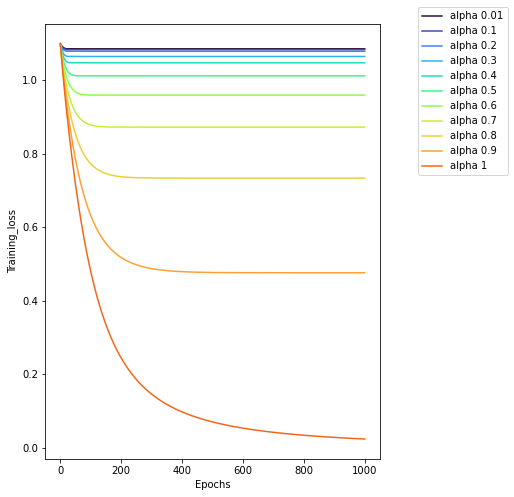

In [25]:
alpha = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="alpha "+str(alpha[i]),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))

Text(0.5, 1.0, 'alpha_=alpha+0.01')

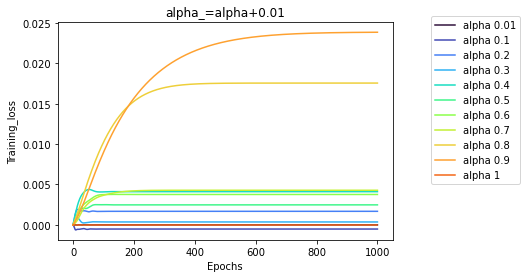

In [26]:
for i in range(len(train_loss_all)):
    temp = np.array(train_loss_all[i]) - np.array(train_loss_alpha_h_all[i])  
    plt.plot(temp,label ="alpha "+str(alpha[i]),color = cm(i*20))
    plt.xlabel("Epochs")
    plt.ylabel("Training_loss")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("alpha_=alpha+0.01")

In [27]:
# train_loss_alpha_h_all[1]

In [28]:
# train_loss_all[1]